# HW07: Deep Learning (due 16th November)

In this homework, you will replicate the heterogenous treatment effect exercise from last week's homework using a deep learning model instead of a machine learning one. 

For those who did not complete this exercise, you will investigate the effect of case management on mental health outcomes. These data come from a randomized control trial where patients were assigned to *intensive* or *standard* case management. In this context, the treatment is being assigned to the **intensive** case management while patients assigned to the **standard** case management belong to the control group.

We will investigate characteristics of individuals who are most and least responsive to the treatment, i.e., to being assigned to the intensive case management. 

In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} tensorflow
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from tensorflow import keras

In [2]:
import statsmodels.formula.api as smf

df = pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta')
df = df.dropna()
pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta', iterator=True).variable_labels()

{'trialid': 'Trial ID',
 'centreid': 'Trial centre',
 'status': 'Patient status at baseline',
 'age': 'Age in years at baseline',
 'sex': 'Sex',
 'afcarib': 'Ethnic group',
 'ocfabth': "Father's social class at birth",
 'chron1l': 'Months since onset of psychosis, logged',
 'hos94': 'Days in hospital for psychiatric reasons: 2 years before baseline',
 'cprs94': 'Psychopathology at baseline (CPRS)',
 'das94': 'Disability at baseline (DAS)',
 'sat94': '(Dis)satisfaction with services at baseline',
 'rand': 'Randomised group',
 'hos96': 'Days in hospital for psychiatric reasons: 2 years after baseline',
 'cprs96': 'Psychopathology at 2 years (CPRS)',
 'sat96': '(Dis)satisfaction with services at 2 years'}

In [3]:
df.head()

,trialid,centreid,status,age,sex,afcarib,ocfabth,chron1l,hos94,cprs94,das94,sat94,rand,hos96,cprs96,sat96
1,107.0,St George's,Out-patient,27.0,male,Other,A,3.178054,80.0,4.0,0.285714,18.0,Intensive case management,27.0,3.0,22.000
2,222005.0,St Mary's,In hospital,41.0,male,Other,D,4.521789,240.0,6.0,0.750000,15.0,Intensive case management,15.0,13.0,9.000
3,222018.0,St Mary's,In hospital,25.0,male,Other,C2,4.094345,48.0,12.0,0.125000,18.0,Intensive case management,263.0,6.0,21.375
5,312015.0,King's,Out-patient,31.0,female,Other,A,4.787492,60.0,28.0,2.375000,20.0,Intensive case management,45.0,19.0,17.000
6,221023.0,St Mary's,In hospital,35.0,male,Afro-Caribbean,C2,4.430817,60.0,25.0,1.571428,24.0,Intensive case management,58.0,27.0,19.125


The treatment variable is $rand$, the post-treatment outcomes are $hos96$, $cprs96$ and $sat96$.

In [4]:
treatvar = 'rand'
df[treatvar].value_counts()

Intensive case management    130
Standard case management     116
Name: rand, dtype: int64

In [5]:
outcomes = ['sat96', 'hos96', 'cprs96']
df[outcomes].describe()

,sat96,hos96,cprs96
count,246.000000,246.000000,246.000000
mean,17.271341,65.500000,17.790587
std,4.723009,104.046722,14.090911
min,9.000000,0.000000,0.000000
25%,14.000000,0.000000,7.000000
50%,17.000000,15.000000,15.000000
75%,20.187500,93.500000,26.000000
max,32.000000,692.000000,71.000000


In addition to these variables we need a set of covariates that we want to use to identify individuals who are most and least responsive to treatment. We also encode categorical covariates and prepare them for the ML model.

In [6]:
#Encoding Categorical covariates and preparing the data for tensorflow
covariates = ['status', 'sex', 'sat94', 'ocfabth', 'hos94', 'das94', 'cprs94', 'age', 'afcarib']
covariates_cat = ['status', 'sex', 'ocfabth', 'afcarib']

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df[covariates_cat] = encoder.fit_transform(df[covariates_cat])
df[covariates] = df[covariates].astype('float32')
df[covariates].head()

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib
1,1.0,1.0,18.0,0.0,80.0,0.285714,4.0,27.0,1.0
2,0.0,1.0,15.0,4.0,240.0,0.750000,6.0,41.0,1.0
3,0.0,1.0,18.0,3.0,48.0,0.125000,12.0,25.0,1.0
5,1.0,0.0,20.0,0.0,60.0,2.375000,28.0,31.0,1.0
6,0.0,1.0,24.0,3.0,60.0,1.571428,25.0,35.0,0.0


In [7]:
# Subset the dataset by treatment and control
# Within each sample, create a training, a test and a validation set

df_treat = df.loc[df[treatvar]=='Intensive case management']
df_control = df.loc[df[treatvar]!='Intensive case management']

In [8]:
##choose one of the three outcomes to analyze
## build two MLP (multilayer perceptron) models to predict the outcome based on the covariates
## the first model should be trained on the treated sample, while the second on the control
y = 'sat96'

# the two MLP models should have with at least 2 hidden layers, ReLU activation, batch normalization, dropout

model_treat = keras.models.Sequential()
model_control = keras.models.Sequential()

model_treat.add(keras.layers.Dense(50, input_dim = len(covariates), activation="relu"))
model_treat.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(.5))

# Now the model will take as input arrays of shape (None,input_dim)
# and output arrays of shape (None, 50).
# Note that after the first layer, you don't need to specify
# the size of the input anymore:

model_treat.add(keras.layers.Dense(25, activation="relu"))
model_treat.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(.5))
model_treat.add(keras.layers.Dense(10, activation="relu"))
model_treat.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(.5))
model_treat.add(keras.layers.Dense(1))


model_control.add(keras.layers.Dense(50, input_dim = len(covariates), activation="relu"))
model_control.add(keras.layers.BatchNormalization())
model_control.add(keras.layers.Dropout(.5))
model_control.add(keras.layers.Dense(25, activation="relu"))
model_control.add(keras.layers.BatchNormalization())
model_control.add(keras.layers.Dropout(.5))
model_control.add(keras.layers.Dense(10, activation="relu"))
model_control.add(keras.layers.BatchNormalization())
model_control.add(keras.layers.Dropout(.5))
model_control.add(keras.layers.Dense(1))


In [9]:
# compile the models
model_treat.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model_control.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

In [10]:
# fit separate models on the treatment dataset and control dataset
# use early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)
# to use validation loss as performance measure to terminate the training.
# In 'min' mode, training will stop when the quantity monitored has stopped decreasing
# verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.
from sklearn.model_selection import train_test_split

print("Treatment Dataset")
Xt = df_treat[covariates]
yt = df_treat[y]
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, random_state=42)

fit_treat = model_treat.fit(Xt_train, yt_train, epochs=20, validation_split=0.2, callbacks=[es])

print(" ")
print("Control Dataset")
Xcontrol = df_control[covariates]
ycontrol = df_control[y]
Xcontrol_train, Xcontrol_test, ycontrol_train, ycontrol_test = train_test_split(Xcontrol, ycontrol, random_state=42)

fit_control = model_control.fit(Xcontrol_train, ycontrol_train, epochs=20, validation_split=0.2, callbacks=[es])

Treatment Dataset
Epoch 1/20


2023-03-17 11:29:07.691713: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 0s 40ms/step - loss: 346.3480 - mean_squared_error: 346.3480 - val_loss: 306.7395 - val_mean_squared_error: 306.7395
Epoch 2/20
3/3 [==============================] - 0s 5ms/step - loss: 357.7677 - mean_squared_error: 357.7677 - val_loss: 306.6607 - val_mean_squared_error: 306.6607
Epoch 2: early stopping
 
Control Dataset
Epoch 1/20
3/3 [==============================] - 0s 33ms/step - loss: 322.6364 - mean_squared_error: 322.6364 - val_loss: 714.8260 - val_mean_squared_error: 714.8260
Epoch 2/20
3/3 [==============================] - 0s 5ms/step - loss: 302.9617 - mean_squared_error: 302.9617 - val_loss: 652.8483 - val_mean_squared_error: 652.8483
Epoch 2: early stopping


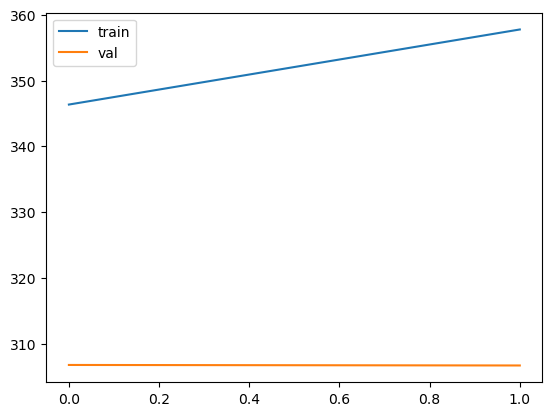

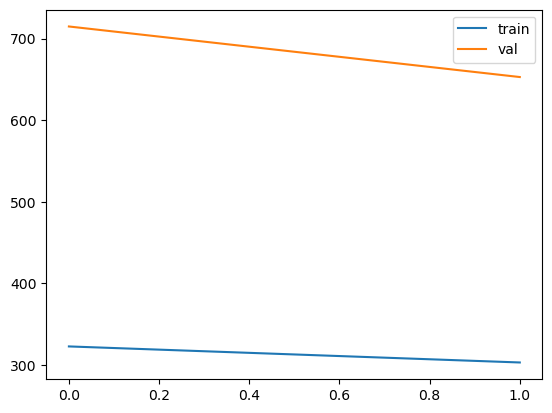

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot performance by epoch
plt.plot(fit_treat.epoch,fit_treat.history['mean_squared_error'])
plt.plot(fit_treat.epoch,fit_treat.history['val_mean_squared_error'])
plt.legend(['train', 'val'], loc='best')
plt.show()
plt.plot(fit_control.epoch,fit_control.history['mean_squared_error'])
plt.plot(fit_control.epoch,fit_control.history['val_mean_squared_error'])
plt.legend(['train', 'val'], loc='best')
plt.show()

In [13]:
# build MLP models with at least 2 hidden layers, ReLU activation, batch normalization, dropout
model_treat2 = keras.models.Sequential()
model_control2 = keras.models.Sequential()

model_treat2 = keras.models.Sequential()
model_treat2.add(keras.layers.Dense(50, input_dim = len(covariates), activation="relu"))
model_treat2.add(keras.layers.Dropout(.3))
model_treat2.add(keras.layers.Dense(25, activation="relu"))
model_treat2.add(keras.layers.Dropout(.3))
model_treat2.add(keras.layers.Dense(10, activation="relu"))
model_treat2.add(keras.layers.Dense(1))


model_control2 = keras.models.Sequential()
model_control2.add(keras.layers.Dense(50, input_dim = len(covariates), activation="relu"))
model_control2.add(keras.layers.Dropout(.3))
model_control2.add(keras.layers.Dense(25, activation="relu"))
model_control2.add(keras.layers.Dropout(.3))
model_control2.add(keras.layers.Dense(10, activation="relu"))
model_control2.add(keras.layers.Dense(1))

model_treat2.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mean_squared_error"])
model_control2.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mean_squared_error"])

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)

from sklearn.model_selection import train_test_split

print("Treatment Dataset")

fit_treat2 = model_treat2.fit(Xt_train, yt_train, epochs=20, validation_split=0.2, callbacks=[es])

print(" ")
print("Control Dataset")


fit_control2 = model_control2.fit(Xcontrol_train, ycontrol_train, epochs=20, validation_split=0.2, callbacks=[es])

Treatment Dataset
Epoch 1/20
3/3 [==============================] - 0s 26ms/step - loss: 1640.4386 - mean_squared_error: 1640.4386 - val_loss: 235.8254 - val_mean_squared_error: 235.8254
Epoch 2/20
3/3 [==============================] - 0s 5ms/step - loss: 716.8540 - mean_squared_error: 716.8540 - val_loss: 176.9415 - val_mean_squared_error: 176.9415
Epoch 2: early stopping
 
Control Dataset
Epoch 1/20
3/3 [==============================] - 0s 26ms/step - loss: 264.6240 - mean_squared_error: 264.6240 - val_loss: 122.3668 - val_mean_squared_error: 122.3668
Epoch 2/20
3/3 [==============================] - 0s 5ms/step - loss: 187.4793 - mean_squared_error: 187.4793 - val_loss: 106.5922 - val_mean_squared_error: 106.5922
Epoch 2: early stopping


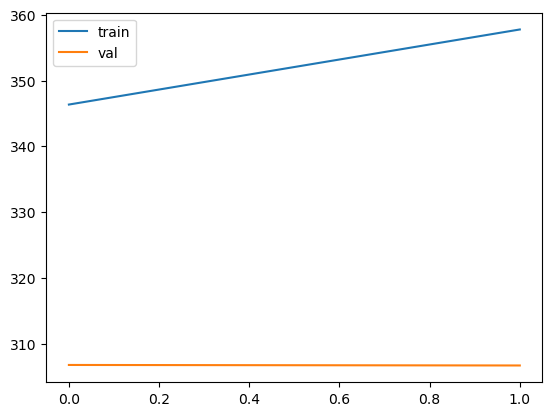

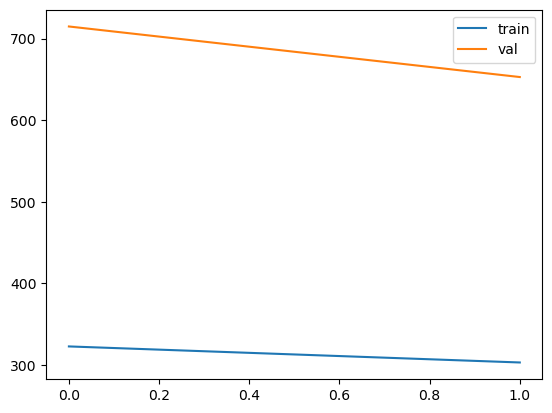

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot performance by epoch
plt.plot(fit_treat.epoch,fit_treat.history['mean_squared_error'])
plt.plot(fit_treat.epoch,fit_treat.history['val_mean_squared_error'])
plt.legend(['train', 'val'], loc='best')
plt.show()
plt.plot(fit_control.epoch,fit_control.history['mean_squared_error'])
plt.plot(fit_control.epoch,fit_control.history['val_mean_squared_error'])
plt.legend(['train', 'val'], loc='best')
plt.show()

In [15]:
##get predicted outcomes using the combined test sets for both models 

test_set = pd.concat([Xt_test,Xcontrol_test]) 
yhat_treat = model_treat.predict(test_set)
yhat_control = model_control.predict(test_set)

2/2 [==============================] - 0s 1ms/step


In [16]:
##find the three individuals in the test set that are most and least responsive to the treatment
##namely the three individuals for who the treatment effect is larger and those for who it is smaller

test_set['treat_effect'] = yhat_treat - yhat_control
test_set = test_set.sort_values('treat_effect', axis=0)
most_least_treat = pd.concat([test_set[:3],test_set[-3:]])
most_least_treat

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib,treat_effect
156,1.0,0.0,9.000,5.0,14.0,0.500000,14.000000,37.0,1.0,2.672244
121,1.0,1.0,9.000,3.0,90.0,1.142857,8.445178,28.0,1.0,2.746894
195,1.0,0.0,12.375,4.0,126.0,0.500000,4.000000,38.0,0.0,2.906835
276,1.0,1.0,22.000,4.0,420.0,1.428571,32.000000,47.0,1.0,12.132431
327,1.0,0.0,23.000,0.0,68.0,4.714283,67.000000,47.0,0.0,14.182419
151,1.0,1.0,24.000,3.0,558.0,2.000000,40.000000,33.0,1.0,14.554812


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

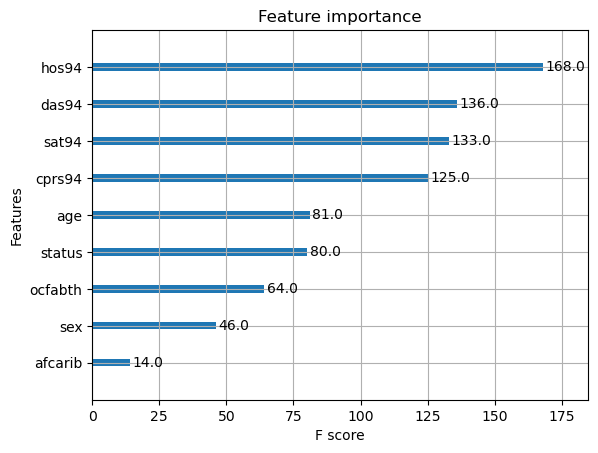

In [17]:
##visualize and comment on the covariates of these individuals 
from xgboost import XGBRegressor
from xgboost import plot_importance

xgb = XGBRegressor()
xgb.fit(test_set[covariates], test_set['treat_effect'])

plot_importance(xgb)